# Лабораторна робота №1
Тема: Підготовка статистичних даних: читання, описова статистика, очистка  
Студент: Луцюк Богдан КН-2  
Варіант: 4  
Дата: 06.10.2025  
Репозиторій: https://github.com/emissuu/UniTasks/tree/main/R/Lab1

## Parameters

In [1]:
library(tidyverse)
library(lubridate)

# Basics
seed <- 16

# Data generation
n <- 500
data_gen <- list(
  number_customers = 4000,
  number_couriers = 200
)

# Dirt multipliers
dirt_gen <- list(
  assigned_at_loss = 0.10,
  picked_at_loss = 0.08,
  delivered_at_loss = 0.06,
  note_loss = 0.06,

  duplicates = 0.02,
  almost_duplicates = 0.015,

  other_date_format = 0.12,
  coma_in_numerics = 0.1,

  negative_delivery_fee = 0.05,
  amplified_distance = 0.007,
  time_anomalies = 0.01,
  canceled_delivered = 0.005,
  confused_lat_lon = 0.015,

  invalid_text = 0.02
)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.2
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the ]8;;http://conflicted.r-lib.org/conflicted package]8;; to force all conflicts to become errors


Warning messages:
1: package ‘tidyverse’ was built under R version 4.5.1 
2: package ‘tidyr’ was built under R version 4.5.1 
3: package ‘readr’ was built under R version 4.5.1 
4: package ‘purrr’ was built under R version 4.5.1 
5: package ‘dplyr’ was built under R version 4.5.1 
6: package ‘stringr’ was built under R version 4.5.1 
7: package ‘forcats’ was built under R version 4.5.1 
8: package ‘lubridate’ was built under R version 4.5.1 


## Section 1

### Генеруємо дані

In [10]:
set.seed(seed)

order_id       <- 1:n
created_at     <- as.POSIXct(
  runif(n, 
    as.numeric(c.POSIXct("2024-04-01 00:00:00")), 
    as.numeric(c.POSIXct("2024-04-30 23:59:59"))
  ),
origin = "1970-01-01", tz = "Europe/Kyiv"
)
status <- sample(c("created", "assigned", "picked", "delivered", "canceled"), n, TRUE)
assigned_at <- if_else(
  status %in% c("assigned", "picked", "delivered") | status == "canceled" & runif(n) < 0.66,
  created_at + sample(10:60, n, TRUE) * 60,
  NA
)
picked_at <- if_else(
  status %in% c("picked", "delivered") | status == "canceled" & is.na(assigned_at) & runif(n) < 0.50,
  assigned_at + sample(10:60, n, TRUE) * 60,
  NA
)
delivered_at <- if_else(
  status == "delivered",
  picked_at + sample(10:60, n, TRUE) * 60,
  NA
)
customer_id <- sample(1:data_gen[["number_customers"]], n, TRUE)
city <- sample(c("Kyiv", "Lviv", "Odesa"), n, TRUE)
lat <- if_else(city == "Kyiv", round(runif(n, 50.259976, 50.555627), 6), 
  if_else(city == "Lviv", round(runif(n, 49.767958, 49.885124), 6),
  if_else(city == "Odesa", round(runif(n, 46.320902, 46.560871), 6),
  NA
)))
lon <- if_else(city == "Kyiv", round(runif(n, 30.282074, 30.759165), 6), 
  if_else(city == "Lviv", round(runif(n, 23.909936, 24.117936), 6),
  if_else(city == "Odesa", round(runif(n, 30.615875, 30.772156), 6),
  NA
)))
distance_km <- round(runif(n, 0.2, 26), 2)
service_level <- sample(c("Standart", "Express"), n, TRUE)
payment_method <- sample(c("Card", "COD"), n, TRUE)
items_count <- sample(1:6, n, TRUE)
order_value <- sample(100:6000, n, TRUE)
delivery_fee <- if_else(service_level == "Standart", 40 + distance_km * 2, 60 + distance_km * 3)
courier_id <- sample(1:data_gen[["number_couriers"]], n, TRUE)
note <- sample(c("fragile", "liquid", "sharp", "perishable", NA, NA, NA, NA), n, TRUE)

data <- data.frame(
  order_id         = order_id,
  created_at       = created_at,
  assigned_at      = assigned_at,
  picked_at        = picked_at,
  delivered_at     = delivered_at,
  status           = status,
  customer_id      = customer_id,
  city             = city,
  lat              = lat,
  lon              = lon,
  distance_km      = distance_km,
  service_level    = service_level,
  payment_method   = payment_method,
  items_count      = items_count,
  order_value      = order_value,
  delivery_fee     = delivery_fee,
  courier_id       = courier_id,
  note             = note,
  stringsAsFactors = FALSE
)

rm(order_id, created_at, assigned_at, picked_at, delivered_at, status, customer_id, city, lat, lon, 
  distance_km, service_level, payment_method, items_count, order_value, delivery_fee, courier_id, note)

glimpse(data)

Rows: 500
Columns: 18
$ order_id       <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, …
$ created_at     <dttm> 2024-04-21 11:50:20, 2024-04-08 07:45:52, 2024-04-14 1…
$ assigned_at    <dttm> 2024-04-21 12:20:20, 2024-04-08 08:40:52, NA, 2024-04-…
$ picked_at      <dttm> 2024-04-21 13:11:20, NA, NA, NA, 2024-04-26 23:02:31, …
$ delivered_at   <dttm> NA, NA, NA, NA, 2024-04-26 23:26:31, NA, NA, NA, NA, N…
$ status         <chr> "picked", "assigned", "canceled", "assigned", "delivere…
$ customer_id    <int> 2106, 3727, 3854, 396, 2217, 672, 3099, 1681, 2207, 231…
$ city           <chr> "Kyiv", "Odesa", "Lviv", "Kyiv", "Kyiv", "Lviv", "Lviv"…
$ lat            <dbl> 50.32855, 46.40073, 49.82669, 50.47731, 50.49614, 49.84…
$ lon            <dbl> 30.47308, 30.64616, 24.08462, 30.35421, 30.45474, 24.04…
$ distance_km    <dbl> 12.91, 4.53, 20.63, 0.70, 7.99, 20.30, 8.98, 15.87, 25.…
$ service_level  <chr> "Standart", "Express", "Standart", "Standart", "Standar…
$ payment_method <

### Забруднюємо їх

In [ ]:
set.seed(seed)

# ===== Gaps =====
data <- data |>
  mutate(
    assigned_at = if_else(runif(n) < dirt_gen[["assigned_at_loss"]], NA, assigned_at),
    picked_at = if_else(runif(n) < dirt_gen[["picked_at_loss"]], NA, picked_at),
    delivered_at = if_else(runif(n) < dirt_gen[["delivered_at_loss"]], NA, delivered_at),
    note = if_else(runif(n) < dirt_gen[["note_loss"]], NA, note)
  )

# ===== Duplicates =====
source_rows <- sample(1:n, round(dirt_gen[["duplicates"]] * n), TRUE)
target_rows <- sample(1:n, round(dirt_gen[["duplicates"]] * n), FALSE)
data[target_rows, ] <- data[source_rows, ]
# rm(source_rows, target_rows)

almost_dupl_size <- round(dirt_gen[["almost_duplicates"]] * n)
source_rows <- sample(1:n, almost_dupl_size, TRUE)
target_rows <- sample(1:n, almost_dupl_size, FALSE)
temp_data <- data[source_rows, ]
temp_data <- temp_data |>
  mutate(
    city = if_else(runif(almost_dupl_size) < 0.6, 
      if_else(runif(almost_dupl_size) < 0.6, toupper(city), paste(city, " ")), city),
    service_level = if_else(runif(almost_dupl_size) < 0.7, 
      if_else(runif(almost_dupl_size) < 0.5, toupper(service_level), paste(" ", service_level)), service_level),
    payment_method = if_else(runif(almost_dupl_size) < 0.4, 
      if_else(runif(almost_dupl_size) < 0.5, tolower(payment_method), paste(payment_method, " ")), payment_method)
  )
data[target_rows, ] <- temp_data
rm(almost_dupl_size, source_rows, target_rows, temp_data)

# ===== Anomalies =====
data <- data |>
  mutate(
    delivery_fee = if_else(
      runif(n) < dirt_gen[["negative_delivery_fee"]],
      if_else(runif(n) < 0.5, 0, (delivery_fee * -1)),
      delivery_fee
    ),
    distance_km = if_else(
      runif(n) < dirt_gen[["amplified_distance"]],
      distance_km * 8,
      distance_km
    ),
    delivered_at = if_else(
      runif(n) < dirt_gen[["time_anomalies"]],
      NA,
      delivered_at
    ),
    picked_at = if_else(
      runif(n) < dirt_gen[["time_anomalies"]] / 2,
      NA,
      picked_at
    )
  )
rows_to_affect <- runif(n) < dirt_gen[["confused_lat_lon"]]
for(row in 1:n)
  if(rows_to_affect[row]) {
    temp = data$lat[row]
    data$lat[row] = data$lon[row]
    data$lon[row] = temp
  }
rm(rows_to_affect, row, temp)

# ===== Types / Formats =====
data <- data |>
  mutate(
    created_at = if_else(
      runif(n) < dirt_gen[["other_date_format"]], 
      format(created_at, "%d.%m.%Y %H:%M"), 
      format(created_at, "%Y-%m-%d %H:%M:%S")),
    assigned_at = if_else(
      runif(n) < dirt_gen[["other_date_format"]], 
      format(assigned_at, "%d.%m.%Y %H:%M"), 
      format(assigned_at, "%Y-%m-%d %H:%M:%S")),
    picked_at = if_else(
      runif(n) < dirt_gen[["other_date_format"]], 
      format(picked_at, "%d.%m.%Y %H:%M"), 
      format(picked_at, "%Y-%m-%d %H:%M:%S")),
    delivered_at = if_else(
      runif(n) < dirt_gen[["other_date_format"]], 
      format(delivered_at, "%d.%m.%Y %H:%M"), 
      format(delivered_at, "%Y-%m-%d %H:%M:%S"))
  )

data <- data |>
  mutate(
    order_value = if_else(
      runif(n) < dirt_gen[["coma_in_numerics"]], 
      order_value |> 
        formatC(format = "f", big.mark = " ", digits = 0) |> 
        as.character(),
      order_value |> as.character()),
    delivery_fee = if_else(
      runif(n) < dirt_gen[["coma_in_numerics"]], 
      sub("\\.", ",", delivery_fee |> 
        formatC(format = "f", big.mark = " ", digits = 2) |> 
        as.character()),
      delivery_fee |> as.character()),
  )

# ===== Text registries =====
data <- data |>
  mutate(
    city = if_else(
      runif(n) < dirt_gen[["invalid_text"]],
      paste(toupper(city), " "),
      city
    ),
    service_level = if_else(
      runif(n) < dirt_gen[["invalid_text"]],
      paste(" ", toupper(service_level)),
      service_level
    ),
    payment_method = if_else(
      runif(n) < dirt_gen[["invalid_text"]],
      paste(tolower(payment_method), " "),
      payment_method
    ),
    note = if_else(
      runif(n) < dirt_gen[["invalid_text"]],
      if_else(is.na(note), " ", paste(" ", note)),
      note
    )
  )

write.csv(data, "..\\raw\\data.csv", row.names = FALSE)

## Section 2
### Описова статистика "до"

New names:
• `` -> `...1`
Rows enumeration:
Rows: 500
Columns: 19
$ ...1           <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, …
$ order_id       <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 105, 11, 12, 13, 14, 15, 16,…
$ created_at     <chr> "21.04.2024 11:50", "2024-04-08 07:45:52", "2024-04-14 …
$ assigned_at    <chr> "2024-04-21 12:20:20", "2024-04-08 08:40:52", NA, "2024…
$ picked_at      <chr> "21.04.2024 13:11", NA, NA, NA, "26.04.2024 23:02", NA,…
$ delivered_at   <chr> NA, NA, NA, NA, "2024-04-26 23:26:31", NA, NA, NA, NA, …
$ status         <chr> "picked", "assigned", "canceled", "assigned", "delivere…
$ customer_id    <dbl> 2106, 3727, 3854, 396, 2217, 672, 3099, 1681, 2207, 205…
$ city           <chr> "Kyiv", "Odesa", "Lviv", "Kyiv", "Kyiv", "Lviv", "Lviv"…
$ lat            <dbl> 50.32855, 46.40073, 49.82669, 50.47731, 50.49614, 49.84…
$ lon            <dbl> 30.47308, 30.64616, 24.08462, 30.35421, 30.45474, 24.04…
$ distance_km    <dbl> 12.91, 4.53, 20.63, 0.70, 7.99,

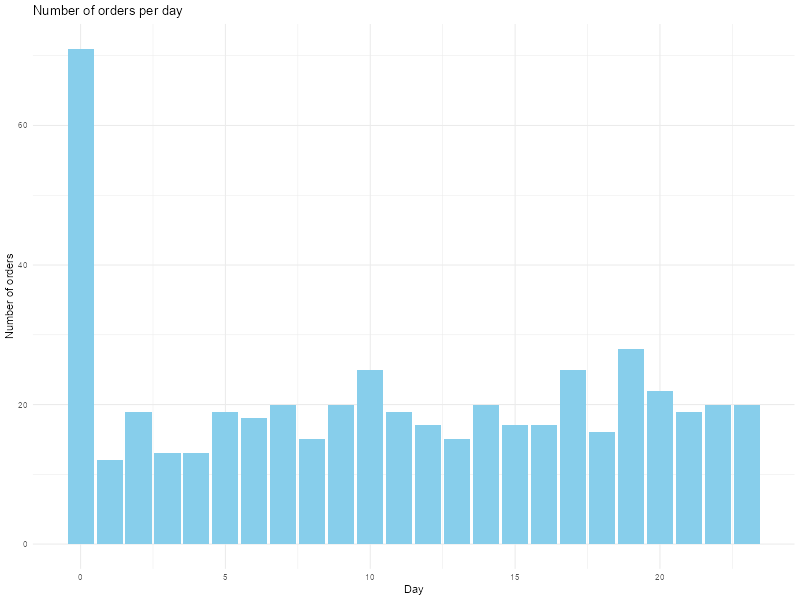

In [ ]:
data <- read_csv("..\\raw\\data.csv", show_col_types = FALSE)

cat("Rows enumeration:\n")
glimpse(data)

gaps <- list(
  created_at = sum(is.na(data$created_at)),
  assigned_at = sum(is.na(data$assigned_at)),
  picked_at = sum(is.na(data$picked_at)),
  delivered_at = sum(is.na(data$delivered_at)),
  note = sum(is.na(data$note))
)
cat("\nGaps number:\n")
cat("Created_at: ", gaps[["created_at"]], " gaps (", gaps[["created_at"]] / n * 100, "%)\n", sep = "")
cat("Assigned_at: ", gaps[["assigned_at"]], " gaps (", gaps[["assigned_at"]] / n * 100, "%)\n", sep = "")
cat("Picked_at: ", gaps[["picked_at"]], " gaps (", gaps[["picked_at"]] / n * 100, "%)\n", sep = "")
cat("Delivered_at: ", gaps[["delivered_at"]], " gaps (", gaps[["delivered_at"]] / n * 100, "%)\n", sep = "")
cat("Note: ", gaps[["note"]], " gaps (", gaps[["note"]] / n * 100, "%)\n", sep = "")

cat("\nDuplicates:", sum(duplicated(data)))
cat("\nAlmost duplicates: ", sum(duplicated(data$order_id)), " (", sum(duplicated(data$order_id)) / n * 100, "%)\n", sep = "")

cat("\nDelivered without delivery date:", sum(data$status == 'delivered' & is.na(data$delivered_at)))
cat("\nDelivered when cancelled:", sum(data$status == "cancelled" & !is.na(data$delivered_at)))
cat("\nCoordinates beyong city borders:", sum(
  data$city == "Kyiv" & (!between(data$lat, 50.259976, 50.555627) | !between(data$lon, 30.282074, 30.759165)) |
  data$city == "Lviv" & (!between(data$lat, 49.767958, 49.885124) | !between(data$lon, 23.909936, 24.117936)) |
  data$city == "Odesa" & (!between(data$lat, 46.320902, 46.560871) | !between(data$lon, 30.615875, 30.772156)), na.rm = TRUE))


cat("\nNumber of delivery_fee, which are not numerics:", suppressWarnings(sum(is.na(as.numeric(str_replace_all(data$delivery_fee, " ", ""))))))
cat("\nNumber of order_value, which are not numerics:", suppressWarnings(sum(is.na(as.numeric(str_replace_all(data$order_value, " ", ""))))))
cat("\nNumber of delivery_fee where value is 0 or lower:", suppressWarnings(sum(as.numeric(str_replace_all(data$delivery_fee, " ", "")) <= 0, na.rm = TRUE)))

cat("\n\nOrders by days:")
cols_to_convert <- c("created_at", "assigned_at", "picked_at", "delivered_at")
data <- data |>
  mutate(across(all_of(cols_to_convert), ymd_hms, tz = "Europe/Kiev"))
data$hour_of_day <- hour(data$created_at)
ggplot(data, aes(x = hour_of_day)) +
  geom_bar(fill = "skyblue") +
  labs(title = "Number of orders per day", x = "Day", y = "Number of orders") +
  theme_minimal()
rm(cols_to_convert, gaps)

Оглядовий аналіз показує, що головною проблемою даних є неконсистентність форматів та типів даних. Ті що мали б бути числовими мають пробіли чи коми, що робить їх рядковими. Також в даних містяться дублікати та багато пропусків. Присутні аномалії. 

## Section 3
### Очистка даних

In [10]:
data <- read_csv("..\\raw\\data.csv", show_col_types = FALSE)

# ===== Cleaning duplicates =====
data <- data |> distinct()
n <- nrow(data)

# ===== Cleaning types and formats
data <- data |>
  mutate(across(all_of(c("created_at", "assigned_at", "picked_at", "delivered_at")), 
    ~parse_date_time(.x, orders = c("Y-m-d H:M:S", "d.m.Y H:M"), tz = "Europe/Kyiv")))
data <- data |>
  mutate(across(all_of(c("order_value", "delivery_fee")), 
    ~as.numeric(str_replace_all(str_replace(.x, ",", "."), "\\s", ""))))

# ===== Cleaning text things =====
data <- data |>
  mutate(across(all_of(c("city", "service_level", "payment_method")), ~str_to_title(str_trim(.))),
  note = if_else(is.na(note), "", str_trim(note))) 

# ===== Cleaning almost duplicates =====
data <- data |> distinct(order_id, .keep_all = TRUE)
n <- nrow(data)

# ===== Cleaning geo anomalies =====
rows_to_affect <- data$lat < 45 & data$lon > 32
for(row in 1:n)
  if(rows_to_affect[row]) {
    temp = data$lat[row]
    data$lat[row] = data$lon[row]
    data$lon[row] = temp
  } 
rm(rows_to_affect, temp, row)

# ===== Cleaning other anomalies =====
data <- data |>
  mutate(delivery_fee = if_else(delivery_fee <= 0, if_else(service_level == "Standart", 60, 90), delivery_fee))

data <- data |>
  mutate(
      delivered_at = if_else(delivered_at < picked_at, NA, delivered_at),
      picked_at = if_else(picked_at < assigned_at, NA, picked_at),
      assigned_at = if_else(assigned_at < created_at, NA, assigned_at))

# ===== Filling timestamps =====
time_diffs <- data |>
  filter(status == "delivered") |>
  mutate(
    assign_delay = as.numeric(difftime(assigned_at, created_at, units = "secs")),
    pick_delay = as.numeric(difftime(picked_at, assigned_at, units = "secs")),
    deliver_delay = as.numeric(difftime(delivered_at, picked_at, units = "secs"))
  ) |>
  group_by(city, service_level) |>
  summarise(
    median_assign = median(assign_delay, na.rm = TRUE),
    median_pick = median(pick_delay, na.rm = TRUE),
    median_deliver = median(deliver_delay, na.rm = TRUE),
    mean_distance = mean(distance_km),
    .groups = 'drop'
  )
data <- data |>
  left_join(time_diffs, by = c("city", "service_level")) |>
    mutate(
      assigned_at = if_else(is.na(assigned_at) & status != "created", created_at + seconds(median_assign), assigned_at),
      picked_at = if_else(is.na(picked_at) & status %in% c("picked", "delivered"), assigned_at + seconds(median_pick), picked_at),
      delivered_at = if_else(is.na(delivered_at) & status == "delivered", picked_at + seconds(median_deliver), delivered_at),
      distance_km = if_else(distance_km > 50, mean_distance, distance_km)
    ) |>
    select(-starts_with("median_"), -mean_distance)


# ===== Validation =====
cat("\n===== Data validation =====\n")
cat("1. Data types of dates and currencies:\n")
cat("Valid date types:", all(sapply(data[, c("created_at", "delivered_at")], is.POSIXct)), "\n")
cat("Valid currencie types:", all(sapply(data[, c("order_value", "delivery_fee")], is.numeric)), "\n")
cat("2. Total duplicates not present:", !any(duplicated(data)), "\n")
cat("3. Timestamps are consequential:", 
  data |>
    filter(status == "delivered") |>
    summarise(all_ok = all(delivered_at >= picked_at & picked_at >= assigned_at & assigned_at >= created_at, na.rm = TRUE)) |>
    pull(all_ok), "\n")
cat("4. Cancelled don't have delivered_at time:",
  data |>
    filter(status == "canceled") |>
    summarise(all_na = all(is.na(delivered_at))) |>
    pull(all_na), "\n")
cat("5. All cordinates are inbounds of Ukraine:", all(data$lat >= 45 & data$lat <= 53 & data$lon >= 22 & data$lon <= 41, na.rm = TRUE), "\n")
cat("6. All distances are between 0.1 and 80 km:", all(data$distance_km >= 0.1 & data$distance_km <= 80, na.rm = TRUE), "\n")
cat("7. All fees are more than 40:", all(data$delivery_fee >= 40, na.rm = TRUE), "\n")
cat("8. All cattegories equal theirs vocabs:", 
  all(unique(data$city) %in% c("Kyiv", "Lviv", "Odesa")) &
  all(unique(data$service_level) %in% c("Standart", "Express")) &
  all(unique(data$payment_method) %in% c("Card", "Cod")), "\n\n")
cat("Data overview:\n")

rm(time_diffs)
write.csv(data, "..\\clean\\data.csv", row.names = FALSE)
glimpse(data)

New names:
• `` -> `...1`

===== Data validation =====
1. Data types of dates and currencies:
Valid date types: TRUE 
Valid currencie types: TRUE 
2. Total duplicates not present: TRUE 
3. Timestamps are consequential: TRUE 
4. Cancelled don't have delivered_at time: TRUE 
5. All cordinates are inbounds of Ukraine: TRUE 
6. All distances are between 0.1 and 80 km: TRUE 
7. All fees are more than 40: TRUE 
8. All cattegories equal theirs vocabs: TRUE 

Data overview:
Rows: 482
Columns: 19
$ ...1           <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, …
$ order_id       <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 105, 11, 12, 13, 14, 15, 16,…
$ created_at     <dttm> 2024-04-21 11:50:00, 2024-04-08 07:45:52, 2024-04-14 1…
$ assigned_at    <dttm> 2024-04-21 12:20:20, 2024-04-08 08:40:52, 2024-04-14 1…
$ picked_at      <dttm> 2024-04-21 13:11:00, NA, NA, NA, 2024-04-26 23:02:00, …
$ delivered_at   <dttm> NA, NA, NA, NA, 2024-04-26 23:26:31, NA, NA, NA, NA, N…
$ status         <chr> "pic

## Section 4
### Оглядова статистика "після" + підсумки

In [17]:
data_clean <- read_csv("..\\clean\\data.csv", show_col_types = FALSE)
data_dirty <- read_csv("..\\raw\\data.csv", show_col_types = FALSE)
n <- nrow(data_clean)

cat("After cleaning summary:\n")
gaps <- list(
  created_at = sum(is.na(data_clean$created_at)),
  assigned_at = sum(is.na(data_clean$assigned_at)),
  picked_at = sum(is.na(data_clean$picked_at)),
  delivered_at = sum(is.na(data_clean$delivered_at)),
  note = sum(is.na(data_clean$note))
)
cat("\nGaps number:\n")
cat("Created_at: ", gaps[["created_at"]], " gaps (", gaps[["created_at"]] / n * 100, "%)\n", sep = "")
cat("Assigned_at: ", gaps[["assigned_at"]], " gaps (", gaps[["assigned_at"]] / n * 100, "%)\n", sep = "")
cat("Picked_at: ", gaps[["picked_at"]], " gaps (", gaps[["picked_at"]] / n * 100, "%)\n", sep = "")
cat("Delivered_at: ", gaps[["delivered_at"]], " gaps (", gaps[["delivered_at"]] / n * 100, "%)\n", sep = "")
cat("Note: ", gaps[["note"]], " gaps (", gaps[["note"]] / n * 100, "%)\n", sep = "")

cat("\nDuplicates:", sum(duplicated(data_clean)))
cat("\nAlmost duplicates: ", sum(duplicated(data_clean$order_id)), " (", sum(duplicated(data_clean$order_id)) / n * 100, "%)\n", sep = "")

cat("\nDelivered without delivery date:", sum(data_clean$status == 'delivered' & is.na(data_clean$delivered_at)))
cat("\nDelivered when cancelled:", sum(data_clean$status == "cancelled" & !is.na(data_clean$delivered_at)))
cat("\nCoordinates beyong city borders:", sum(
  data_clean$city == "Kyiv" & (!between(data_clean$lat, 50.259976, 50.555627) | !between(data_clean$lon, 30.282074, 30.759165)) |
  data_clean$city == "Lviv" & (!between(data_clean$lat, 49.767958, 49.885124) | !between(data_clean$lon, 23.909936, 24.117936)) |
  data_clean$city == "Odesa" & (!between(data_clean$lat, 46.320902, 46.560871) | !between(data_clean$lon, 30.615875, 30.772156)), na.rm = TRUE))


cat("\nNumber of delivery_fee, which are not numerics:", suppressWarnings(sum(is.na(as.numeric(str_replace_all(data_clean$delivery_fee, " ", ""))))))
cat("\nNumber of order_value, which are not numerics:", suppressWarnings(sum(is.na(as.numeric(str_replace_all(data_clean$order_value, " ", ""))))))
cat("\nNumber of delivery_fee where value is 0 or lower:", suppressWarnings(sum(as.numeric(str_replace_all(data_clean$delivery_fee, " ", "")) <= 0, na.rm = TRUE)))
rm(gaps)

New names:
• `` -> `...1`
After cleaning summary:

Gaps number:
Created_at: 0 gaps (0%)
Assigned_at: 91 gaps (18.87967%)
Picked_at: 284 gaps (58.92116%)
Delivered_at: 383 gaps (79.46058%)
Note: 270 gaps (56.0166%)

Duplicates: 0
Almost duplicates: 0 (0%)

Delivered without delivery date: 0
Delivered when cancelled: 0
Coordinates beyong city borders: 0
Number of delivery_fee, which are not numerics: 0
Number of order_value, which are not numerics: 0
Number of delivery_fee where value is 0 or lower: 0

Chart 1: Delivery time

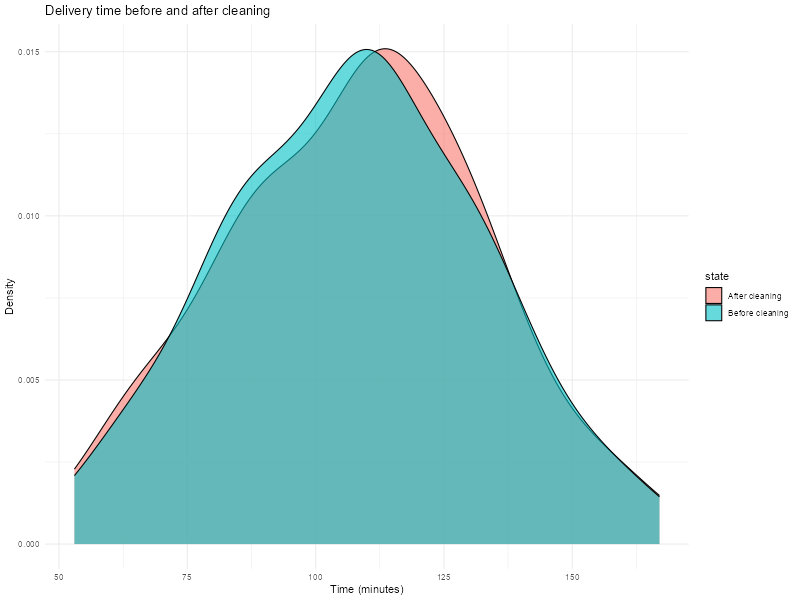

In [15]:
cat("Chart 1: Delivery time")
data_dirty_for_plot <- data_dirty |>
  mutate(
    created_at = parse_date_time(created_at, orders = c("Y-m-d H:M:S", "d.m.Y H:M")),
    delivered_at = parse_date_time(delivered_at, orders = c("Y-m-d H:M:S", "d.m.Y H:M"))
  ) |>
  mutate(duration_minutes_dirty = as.numeric(difftime(delivered_at, created_at, units = "mins")))
data_clean$duration_minutes_clean <- as.numeric(difftime(data_clean$delivered_at, data_clean$created_at, units = "mins"))
plot_data_duration <- bind_rows(
  data_dirty_for_plot |> select(duration = duration_minutes_dirty) |> mutate(state = "Before cleaning"),
  data_clean |> select(duration = duration_minutes_clean) |> mutate(state = "After cleaning")
)
ggplot(plot_data_duration |> filter(duration > 0 & duration < 240), aes(x = duration, fill = state)) +
  geom_density(alpha = 0.6) +
  labs(
    title = "Delivery time before and after cleaning",
    x = "Time (minutes)",
    y = "Density"
  ) +
  theme_minimal()
data_clean <- data_clean |> select(-duration_minutes_clean)
rm(plot_data_duration)



Chart 2: Delivery cost

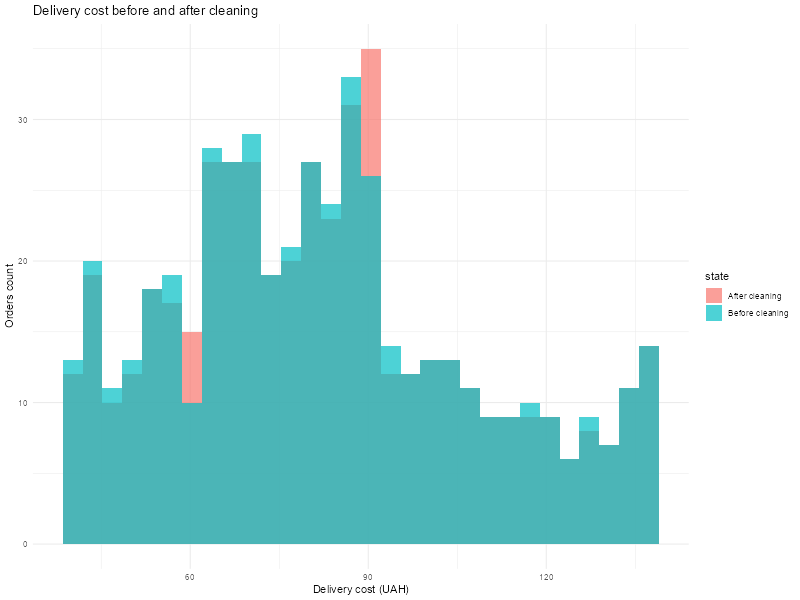

In [16]:
cat("\n\nChart 2: Delivery cost")
data_dirty_for_plot$delivery_fee_dirty <- as.numeric(str_replace_all(str_replace(data_dirty$delivery_fee, ",", "."), "\\s", ""))
plot_data_fee <- bind_rows(
  data_dirty_for_plot |> select(fee = delivery_fee_dirty) |> mutate(state = "Before cleaning"),
  data_clean |> select(fee = delivery_fee) |> mutate(state = "After cleaning")
)
ggplot(plot_data_fee |> filter(fee > 0 & fee < 200), aes(x = fee, fill = state)) +
  geom_histogram(position = "identity", alpha = 0.7, bins = 30) +
  labs(
    title = "Delivery cost before and after cleaning",
    x = "Delivery cost (UAH)",
    y = "Orders count"
  ) +
  theme_minimal()
rm(plot_data_fee, data_dirty_for_plot)

Короткі висновки по очистці даних
  
Спочатку дані мали пропуски, дублі, майже дублі, аномалії, що робило дані важкими для обробки. Тепер же все це було усунуто і дані тепер можна назвати надійними і готовими для обробки. Проте, варто згадати й за деякі компроміси, на які довелось піти задля заповнення пропусків. Деякі значення в часі та цінах доставки довелось замінити на прогнозовані. За допомогою чистки числових полів тепер дані можна використовувати для розрахунків і прогнозів.

## Section 5
### 10 KPI з очищення даних

In [32]:
data_clean <- read_csv("..\\clean\\data.csv", show_col_types = FALSE)
data_dirty <- read_csv("..\\raw\\data.csv", show_col_types = FALSE)
n <- nrow(data_clean)

sla_standards <- c(Express = 60, Standart = 90)
data_clean <- data_clean |>
  mutate(
    duration_minutes = as.numeric(difftime(delivered_at, created_at, units = "mins")),
    sla = if_else(service_level == "Express", sla_standards["Express"], sla_standards["Standart"]),
    on_time = duration_minutes <= sla
  )

# ===== 1. On-time rate  =====
on_time_rate_total <- mean(data_clean$on_time, na.rm = TRUE)
on_time_rate_by_group <- data_clean |>
  group_by(city, service_level) |>
  summarise(on_time_rate = mean(on_time, na.rm = TRUE) * 100, .groups = 'drop')

cat("\n===== KPI #1: On-Time rate =====\n")
cat("On-Time Rate:", scales::percent(on_time_rate_total), "\n")
print(on_time_rate_by_group)
cat("\n1. On-Time Rate (SLA)\n")

# Розрахунок "ДО" на "брудних" даних
data_dirty_sla <- data_dirty %>%
  mutate(
    created_at = parse_date_time(created_at, orders = c("Y-m-d H:M:S", "d.m.Y H:M")),
    delivered_at = parse_date_time(delivered_at, orders = c("Y-m-d H:M:S", "d.m.Y H:M")),
    duration_minutes = as.numeric(difftime(delivered_at, created_at, units = "mins")),
    service_level = str_to_title(str_trim(service_level)),
    sla = if_else(service_level == "Express", 60, 90),
    on_time = duration_minutes <= sla
  ) %>%
  filter(!is.na(on_time)) # ВАЖЛИВО: рахуємо тільки там, де є дані

sla_before <- mean(data_dirty_sla$on_time)
coverage_before <- nrow(data_dirty_sla) / nrow(data_dirty)

cat(sprintf("   - До очистки: %s (розраховано лише на %s даних)\n", 
            scales::percent(sla_before), scales::percent(coverage_before)))
cat(sprintf("   - Після очистки: %s (розраховано на 100%% даних)\n", scales::percent(on_time_rate_total)))
rm(on_time_rate_total, on_time_rate_by_group)

# ===== 2. Median and IQR of delivery time =====
median_duration <- median(data_clean$duration_minutes, na.rm = TRUE)
iqr_duration <- IQR(data_clean$duration_minutes, na.rm = TRUE)

cat("\n===== KPI #2: Delivery time =====\n")
cat("Median delivery time:", round(median_duration, 1), "minutes\n")
cat("IQR of delivery time:", round(iqr_duration, 1), "minutes\n")
rm(median_duration, iqr_duration)

# ===== 3. Average delay of assignment and pickup =====
delays <- data_clean |>
  summarise(
    avg_assign_delay_min = mean(as.numeric(difftime(assigned_at, created_at, units = "mins")), na.rm = TRUE),
    avg_pick_delay_min = mean(as.numeric(difftime(picked_at, assigned_at, units = "mins")), na.rm = TRUE)
  )

cat("\n===== KPI #3: Average delays =====\n")
print(delays)
rm(delays)

# ===== 4. Cancelation rate =====
cancellation_rate <- mean(data_clean$status == "canceled")
cancellation_patterns <- data_clean |>
  filter(status == "canceled") |>
  group_by(city, service_level) |>
  summarise(count = n(), .groups = 'drop') |>
  arrange(desc(count))

cat("\n===== KPI #4: Cancelations =====\n")
cat("Total cancelation rate:", scales::percent(cancellation_rate), "\n")
print(cancellation_patterns)
rm(cancellation_rate, cancellation_patterns)

# ===== 5. Average tarifs (uah/km) =====
avg_tariff_rate <- data_clean |>
  filter(distance_km > 0) |>
  summarise(avg_rate_uah_km = mean(delivery_fee / distance_km, na.rm = TRUE))

cat("\n===== KPI #5: Average tarifs =====\n")
print(avg_tariff_rate)
rm(avg_tariff_rate)

# ===== 6. Average order value by payment method =====
aov_by_payment <- data_clean |>
  group_by(payment_method) |>
  summarise(avg_order_value = mean(order_value, na.rm = TRUE))

cat("\n===== KPI #6: Average order value =====\n")
print(aov_by_payment)
rm(aov_by_payment)

# ===== 7. Distance distribution and it's correlation with duration =====
distance_dist <- quantile(data_clean$distance_km, probs = c(0.5, 0.9, 0.95), na.rm = TRUE)
correlation <- cor(data_clean$distance_km, data_clean$duration_minutes, use = "complete.obs")

cat("\n===== KPI #7: Відстань =====\n")
cat("Distribution distance_km (p50/p90/p95):\n")
print(distance_dist)
cat("Distance and duration correlation:", round(correlation, 3), "\n")
rm(distance_dist, correlation)

# ===== 8. Cleaned geo-dirt rate =====
cat("\n===== KPI #8: Cleaned geo-dirt =====\n")
geo_errors_found_count <- sum(data_dirty$lat < 45, na.rm = TRUE)
geo_error_share <- geo_errors_found_count / nrow(data_dirty)
cat("Cleaned geo-dirt rate:", scales::percent(geo_error_share), "\n")
rm(geo_errors_found_count, geo_error_share)

# ===== 9. Top 5 couriers =====
top_couriers <- data_clean |>
  filter(status == "delivered") |>
  group_by(courier_id) |>
  summarise(
    total_deliveries = n(),
    median_duration_min = median(duration_minutes, na.rm = TRUE)
  ) |>
  arrange(desc(total_deliveries)) |>
  head(5)

cat("\n===== KPI #9: Top 5 couriers =====\n")
print(top_couriers)
rm(top_couriers)

# ===== 10. Percentage of changed rows =====
cat("\n--- KPI #10: Data dirtieness degree (how bad is it?) ---\n")
bad_format_mask <- grepl(" ", data_dirty$order_value) | grepl(",", data_dirty$delivery_fee) | grepl("\\.", data_dirty$created_at)
bad_text_mask <- grepl("^\\s|\\s$", data_dirty$service_level) | (data_dirty$service_level != str_to_title(str_trim(data_dirty$service_level)))
bad_fee_mask <- as.numeric(str_replace_all(str_replace(data_dirty$delivery_fee, ",", "."), "\\s", "")) <= 0
bad_geo_mask <- data_dirty$lat < 45
duplicate_mask <- duplicated(data_dirty$order_id) | duplicated(data_dirty$order_id, fromLast = TRUE)
bad_fee_mask[is.na(bad_fee_mask)] <- FALSE
bad_geo_mask[is.na(bad_geo_mask)] <- FALSE
combined_dirty_mask <- bad_format_mask | bad_text_mask | bad_fee_mask | bad_geo_mask | duplicate_mask
dirty_rows_count <- sum(combined_dirty_mask, na.rm = TRUE)
dirtiness_score <- dirty_rows_count / nrow(data_dirty)

cat("Number of unique rows that were changed:", dirty_rows_count, "\n")
cat("Data dirtieness degree (How many rows ware affected):", scales::percent(dirtiness_score, accuracy = 0.1), "\n")

rm(bad_format_mask, bad_text_mask, bad_fee_mask, bad_geo_mask, duplicate_mask, combined_dirty_mask, dirty_rows_count, dirtiness_score, sla_standards)
data_clean <- data_clean |> select(-sla, -on_time, -duration_minutes)

New names:
• `` -> `...1`

===== KPI #1: On-Time rate =====
On-Time Rate: 16% 
# A tibble: 6 × 3
  city  service_level on_time_rate
  <chr> <chr>                <dbl>
1 Kyiv  Express               0   
2 Kyiv  Standart             35   
3 Lviv  Express               6.67
4 Lviv  Standart             41.7 
5 Odesa Express               0   
6 Odesa Standart             15.8 

===== KPI #2: Delivery time =====
Median delivery time: 111 minutes
IQR of delivery time: 37 minutes

===== KPI #3: Average delays =====
# A tibble: 1 × 2
  avg_assign_delay_min avg_pick_delay_min
                 <dbl>              <dbl>
1                 35.9               35.6

===== KPI #4: Cancelations =====
Total cancelation rate: 21% 
# A tibble: 6 × 3
  city  service_level count
  <chr> <chr>         <int>
1 Lviv  Standart         22
2 Kyiv  Standart         19
3 Kyiv  Express          18
4 Lviv  Express          18
5 Odesa Express          14
6 Odesa Standart         12

===== KPI #5: Average tarifs =====



1. On-Time Rate (SLA)
   - До очистки: 17% (розраховано лише на 20% даних)
   - Після очистки: 16% (розраховано на 100% даних)
   => Бізнес-висновок: На брудних даних ми бачили завищений показник SLA, оскільки аналізували лише 'зручні' замовлення без пропусків. Очищені дані показують більш реалістичну, хоча й нижчу, ефективність, що дозволяє адекватно реагувати на проблеми.
